# Exploration Strategies in Bandit Algorithms

This notebook gives a comparison of epsilon greedy strategy vs thompson sampling for exploration strategy in Bandit algorithms.

### References
This code is heavily based on the following.
* https://towardsdatascience.com/solving-multiarmed-bandits-a-comparison-of-epsilon-greedy-and-thompson-sampling-d97167ca9a50
* https://github.com/conormm/bandit_algorithms/blob/master/bandits_post_code.py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import beta

In [2]:
cmap = plt.get_cmap("tab10", 10)
#cmap = plt.cm.tab10(list(range(len(machines))))
n_trials = 10000

sns.set_style("whitegrid")
get_ipython().run_line_magic('matplotlib', 'inline')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [3]:
class Environment:
    def __init__(self, variants, payouts, n_trials, variance=False):
        self.variants = variants
        if variance:
            self.payouts = np.clip(payouts + np.random.normal(0, 0.04, size=len(variants)), 0, .2)
        else:
            self.payouts = payouts
        #self.payouts[5] = self.payouts[5] if i < n_trials/2 else 0.1
        self.n_trials = n_trials
        self.total_reward = 0
        self.n_k = len(variants)
        self.shape = (self.n_k, n_trials)
        
    def run(self, agent):
        """Run the simulation with the agent. 
        agent must be a class with choose_k and update methods."""
        
        for i in range(self.n_trials):
            # agent makes a choice
            x_chosen = agent.choose_k()
            # Environment returns reward
            reward = np.random.binomial(1, p=self.payouts[x_chosen])
            # agent learns of reward
            agent.reward = reward
            # agent updates parameters based on the data
            agent.update()
            self.total_reward += reward
        
        agent.collect_data()
        
        return self.total_reward

In [4]:
class BaseSampler:
    
    def __init__(self, env, n_samples=None, n_learning=None, e=0.05):
        self.env = env
        self.shape = (env.n_k, n_samples)
        self.variants = env.variants
        self.n_trials = env.n_trials
        self.payouts = env.payouts
        self.ad_i = np.zeros(env.n_trials)
        self.r_i = np.zeros(env.n_trials)
        self.thetas = np.zeros(self.n_trials)
        self.regret_i = np.zeros(env.n_trials)
        self.thetaregret = np.zeros(self.n_trials)
        
        self.a = np.ones(env.n_k) 
        self.b = np.ones(env.n_k) 
        self.theta = np.zeros(env.n_k)
        self.data = None
        self.reward = 0
        self.total_reward = 0
        self.k = 0
        self.i = 0
        
        self.n_samples = n_samples
        self.n_learning = n_learning
        self.e = e
        self.ep = np.random.uniform(0, 1, size=env.n_trials)
        self.exploit = (1 - e)
        
    def collect_data(self):
        
        self.data = pd.DataFrame(dict(ad=self.ad_i, reward=self.r_i, regret=self.regret_i))

In [5]:
class RandomSampler(BaseSampler):
    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        
        self.k = np.random.choice(self.variants)
        
        return self.k
    
    def update(self):
        # nothing to update
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        #self.regret_i[self.i] = np.max(self.thetaregret) - self.theta[self.k]
        #self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.theta) - self.theta[self.k]
        
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [6]:
class eGreedy(BaseSampler):

    def __init__(self, env, n_learning, e):
        super().__init__(env, n_learning, e)
        

    def choose_k(self):

        # e% of the time take a random draw from machines
        # random k for n learning trials, then the machine with highest theta
        self.k = np.random.choice(self.variants) if self.i < self.n_learning else np.argmax(self.theta)
        # with 1 - e probability take a random sample (explore) otherwise exploit
        self.k = np.random.choice(self.variants) if self.ep[self.i] > self.exploit else self.k
        return self.k
        # every 100 trials update the successes

        # update the count of successes for the chosen machine
    def update(self):
        
        # update the probability of payout for each machine
        self.a[self.k] += self.reward
        self.b[self.k] += 1
        self.theta = self.a/self.b

        #self.total_reward += self.reward
        #self.regret_i[self.i] = np.max(self.theta) - self.theta[self.k]
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]
 
        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1

In [7]:
class ThompsonSampler(BaseSampler):

    def __init__(self, env):
        super().__init__(env)
        
    def choose_k(self):
        # sample from posterior (this is the thompson sampling approach)
        # this leads to more exploration because machines with > uncertainty can then be selected as the machine
        self.theta = np.random.beta(self.a, self.b)
        # select machine with highest posterior p of payout
        self.k = self.variants[np.argmax(self.theta)]
        #self.k = np.argmax(self.a/(self.a + self.b))
        return self.k
    
    def update(self):
       
        #update dist (a, b) = (a, b) + (r, 1 - r) 
        self.a[self.k] += self.reward
        self.b[self.k] += 1 - self.reward # i.e. only increment b when it's a swing and a miss. 1 - 0 = 1, 1 - 1 = 0
        
        #self.thetaregret[self.i] = self.thetaregret[self.i]
        #self.regret_i[self.i] = np.max(self.theta) - self.theta[self.k]
        self.thetas[self.i] = self.theta[self.k]
        self.thetaregret[self.i] = np.max(self.thetas) - self.theta[self.k]

        self.ad_i[self.i] = self.k
        self.r_i[self.i] = self.reward
        self.i += 1


In [8]:
machines = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
payouts = [0.023, 0.03, 0.029, 0.001, 0.05, 0.06, 0.0234, 0.005, 0.01, 0.011]
labels = ["V" + str(i) + (str(p)) for i, p in zip(machines, payouts)]
assert len(machines) == len(payouts)

In [9]:
en0 = Environment(machines, payouts, n_trials)
rs = RandomSampler(env=en0)
en0.run(agent=rs)

239

In [10]:
en1 = Environment(machines, payouts, n_trials)
eg = eGreedy(env=en1, n_learning=500, e=0.1)
en1.run(agent=eg)

473

In [11]:
en2 = Environment(machines, payouts, n_trials)
tsa = ThompsonSampler(env=en2)
en2.run(agent=tsa)

557

In [12]:
n_tests = 100
rs_scores = np.zeros(n_tests)
egreedy_scores = np.zeros(n_tests)
ts_scores = np.zeros(n_tests)

for i in range(n_tests):
    en0 = Environment(machines, payouts, 10000)
    rs = RandomSampler(env=en0)
    rs_scores[i] = en0.run(agent=rs)
    
    en1 = Environment(machines, payouts, 10000)
    eg = eGreedy(env=en1, n_learning=1000, e=0.1)
    egreedy_scores[i] = en1.run(agent=eg)
    
    en2 = Environment(machines, payouts, 10000)
    tsa = ThompsonSampler(env=en2)
    ts_scores[i] = en2.run(agent=tsa)
    
print("Done!")

Done!


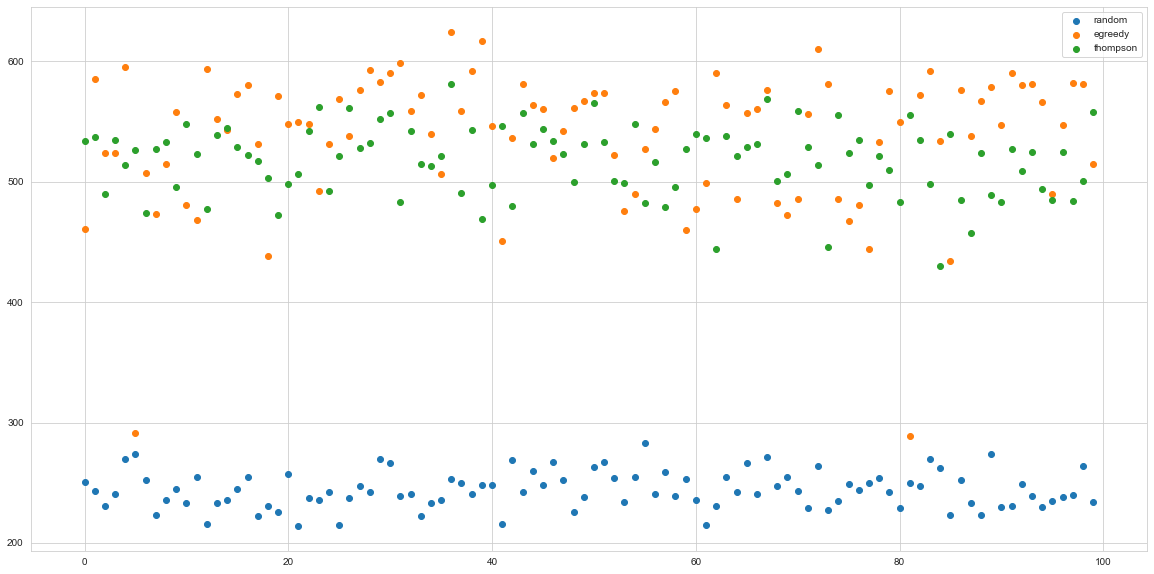

In [13]:
plt.figure(figsize=(20,10))
x = np.arange(0, 100)
plt.scatter(x,rs_scores, label="random");
plt.scatter(x,egreedy_scores, label="egreedy")
plt.scatter(x,ts_scores, label="thompson");
plt.legend();

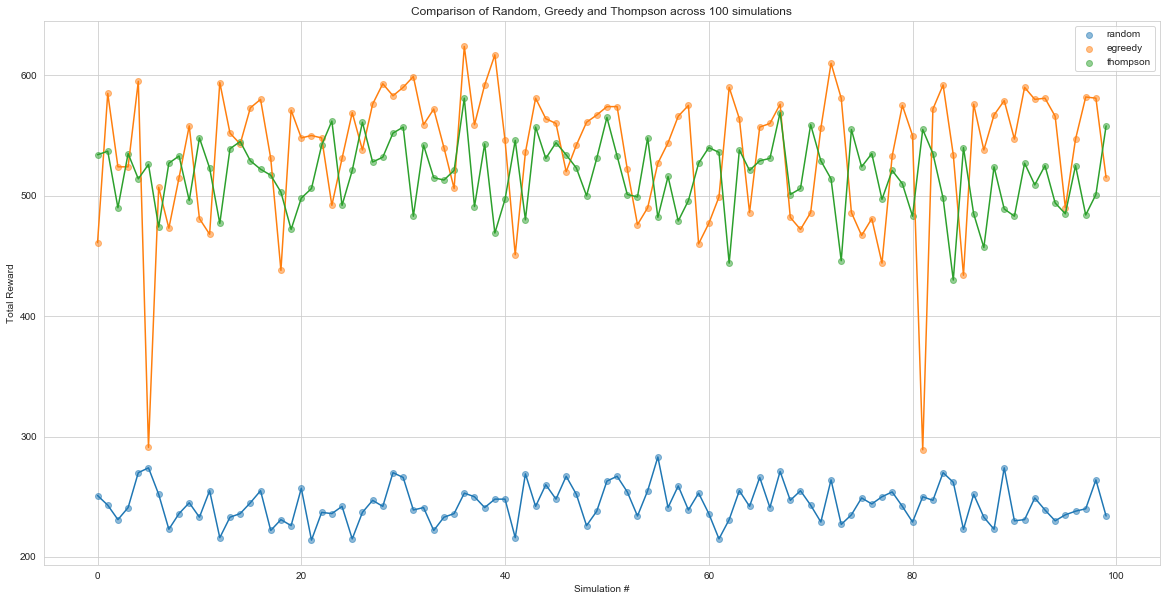

In [14]:
plt.figure(figsize=(20,10))
x = np.arange(0, 100)
plt.scatter(x, rs_scores, label="random", alpha=0.5);
plt.scatter(x, egreedy_scores, label="egreedy", alpha=0.5)
plt.scatter(x, ts_scores, label="thompson", alpha=0.5);
plt.legend();
plt.plot(rs_scores, label="random");
plt.plot(egreedy_scores, label="egreedy")
plt.plot(ts_scores, label="thompson");
plt.xlabel("Simulation #")
plt.ylabel("Total Reward");
plt.title("Comparison of Random, Greedy and Thompson across 100 simulations")
plt.show()

In [15]:
print(rs_scores.mean())
print(egreedy_scores.mean())
print(ts_scores.mean())

244.07
536.78
517.31


In [16]:
def plot_k_choices(agent, env, model):
    plt.figure(figsize=(20,8))
    x = np.arange(0, agent.n_trials)
    plt.scatter(x, agent.ad_i, cmap=cmap, c=agent.ad_i, marker=".", alpha=1)
    plt.title("model", fontsize=16, fontweight="bold")
    plt.xlabel("Trial", fontsize=16, fontweight="bold")
    plt.ylabel("Variant", fontsize=16, fontweight="bold")
    plt.yticks(list(range(10)))
    plt.colorbar();

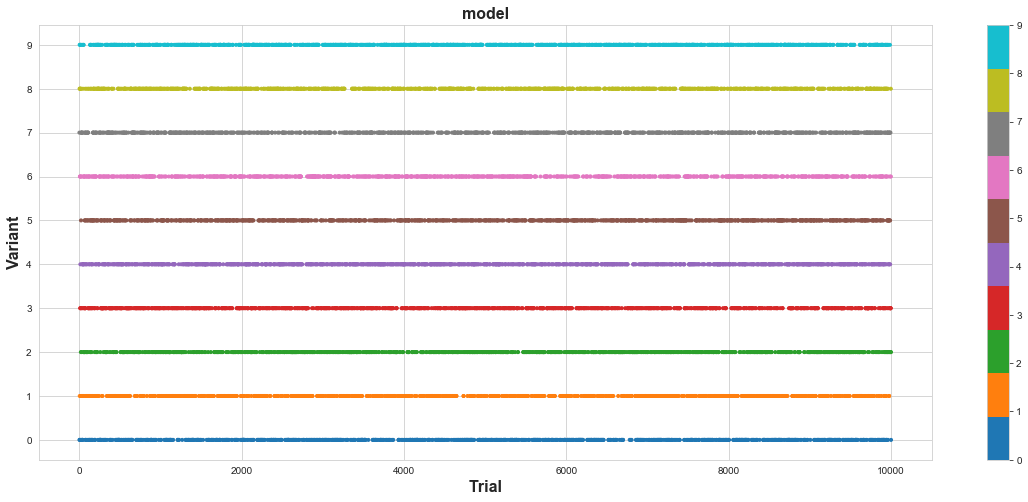

In [17]:
plot_k_choices(rs, en0, "Random sampler")

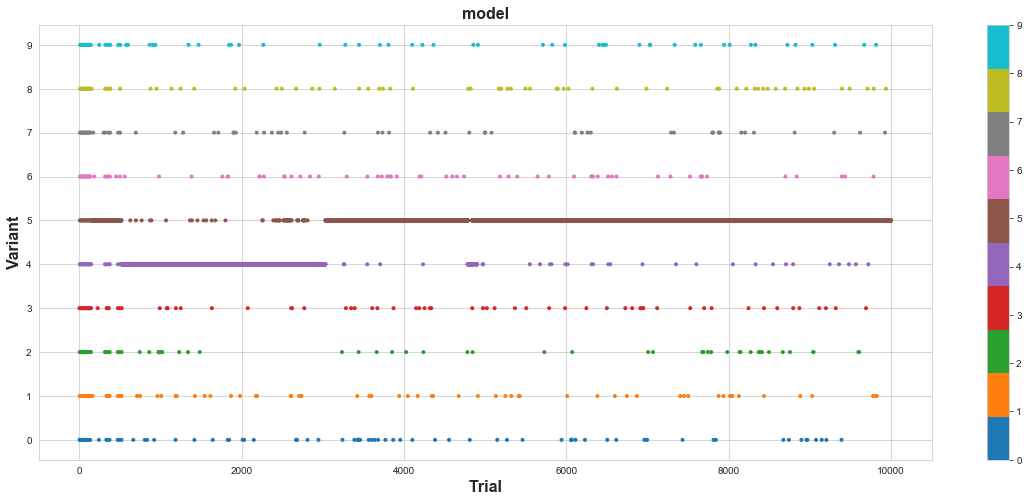

In [18]:
plot_k_choices(eg, en1, "Epsilon greedy")

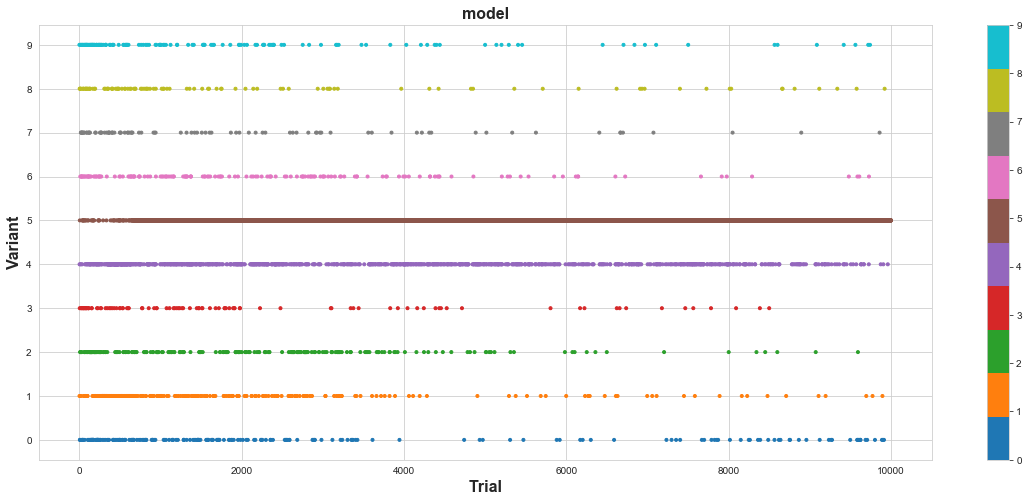

In [19]:
plot_k_choices(tsa, en2, "Thompson Sampling")

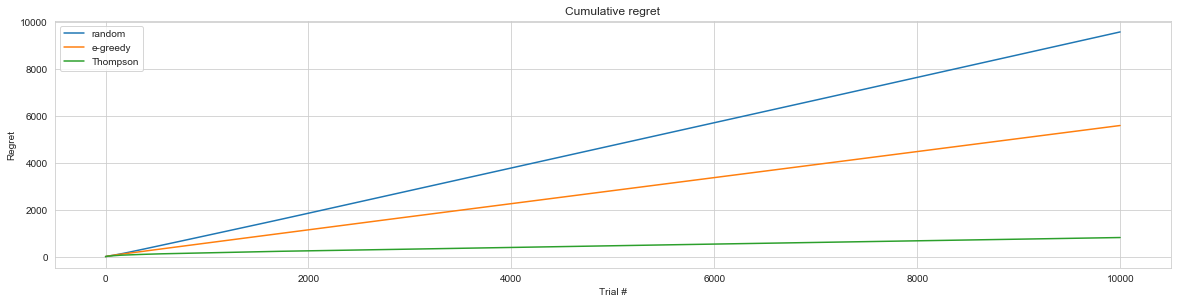

In [20]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(np.cumsum(1 - rs.thetaregret), label="random")
plt.plot(np.cumsum(1 - eg.thetaregret), label="e-greedy")
plt.plot(np.cumsum(1 - tsa.thetaregret), label="Thompson")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Cumulative regret")
plt.legend()
plt.show()

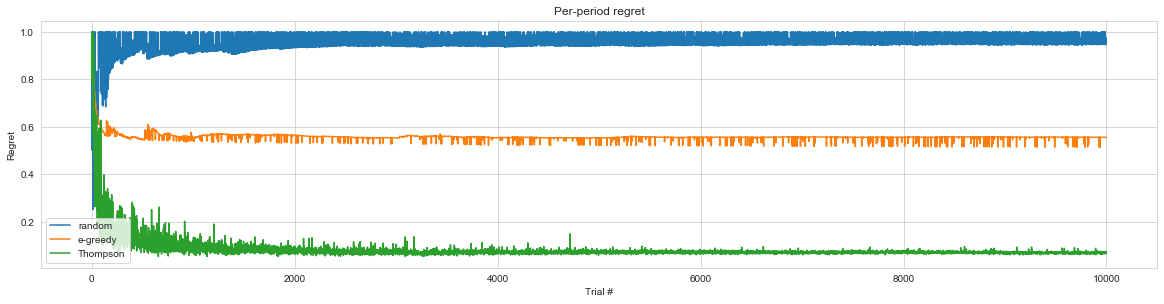

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(212)
plt.plot(1 - rs.thetaregret, label="random")
plt.plot(1 - eg.thetaregret, label="e-greedy")
plt.plot(1 - tsa.thetaregret, label="Thompson")
plt.xlabel("Trial #")
plt.ylabel("Regret")
plt.title("Per-period regret")
plt.legend()
plt.show()

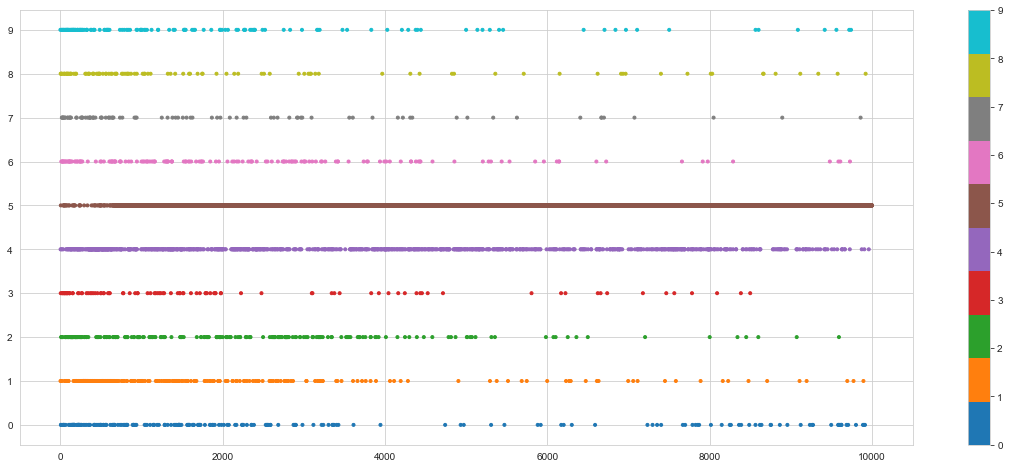

In [22]:
plt.figure(figsize=(20,8))
xd = np.arange(0, eg.n_trials)
cmap = plt.cm.get_cmap("tab10", 10)
plt.scatter(xd, tsa.ad_i, cmap=cmap, c=tsa.ad_i, marker=".", alpha=1)
plt.yticks(list(range(10)))
plt.colorbar()
plt.show()

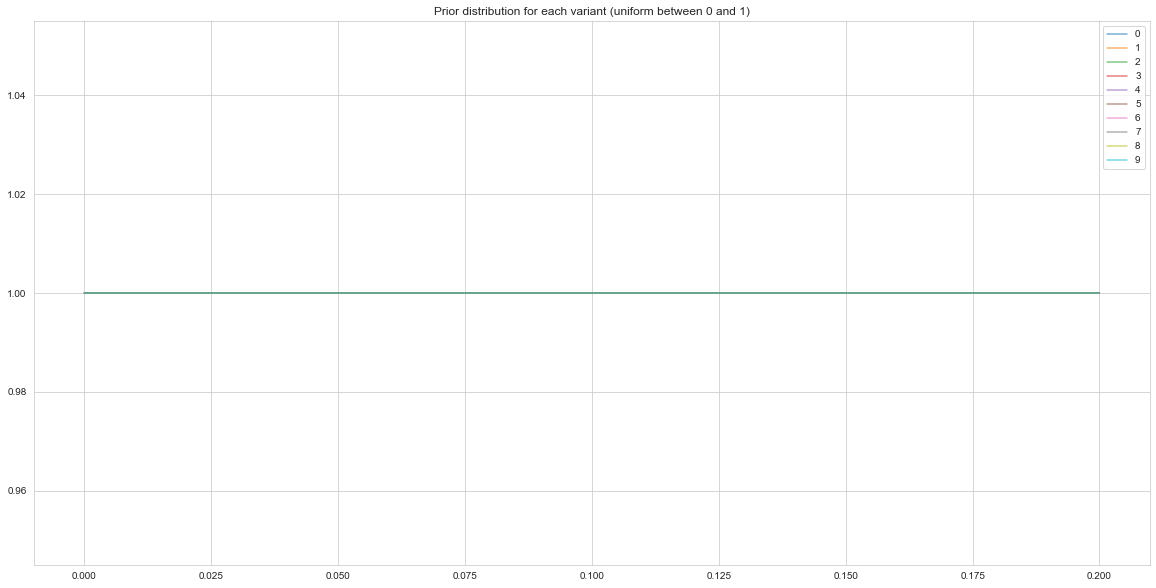

In [23]:
x = np.arange(0, .2, 0.0001)
cmap = list(plt.cm.tab10(list(range(len(machines)))))
plt.figure(figsize=(20, 10))
# plot 1
n_rounds = 0
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Prior distribution for each variant (uniform between 0 and 1)")
plt.legend()
plt.show()

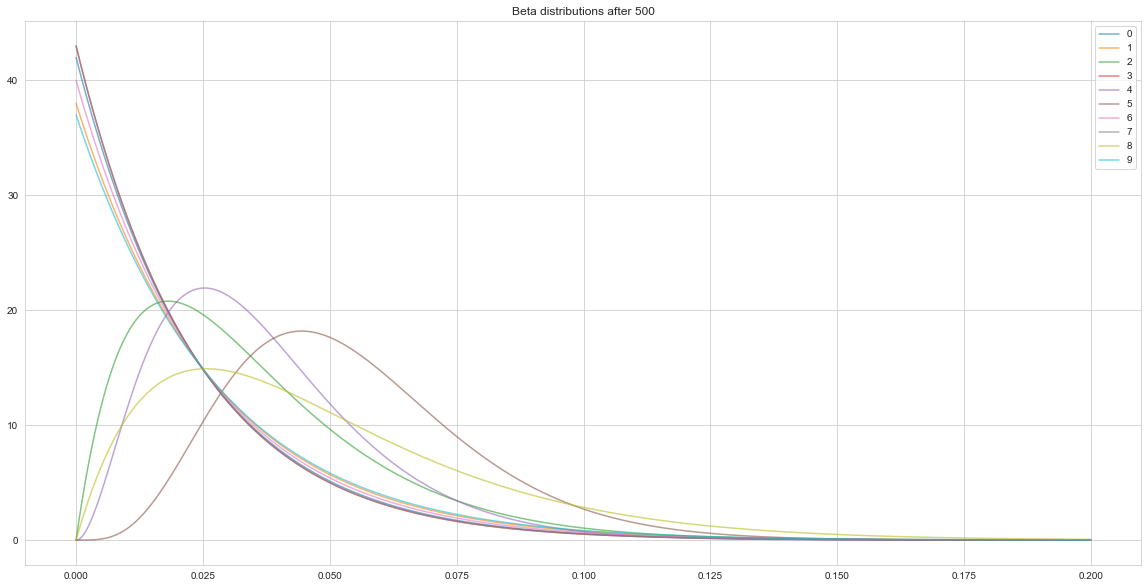

In [24]:
n_rounds = 500
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
plt.figure(figsize=(20, 10))
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend()
plt.show()

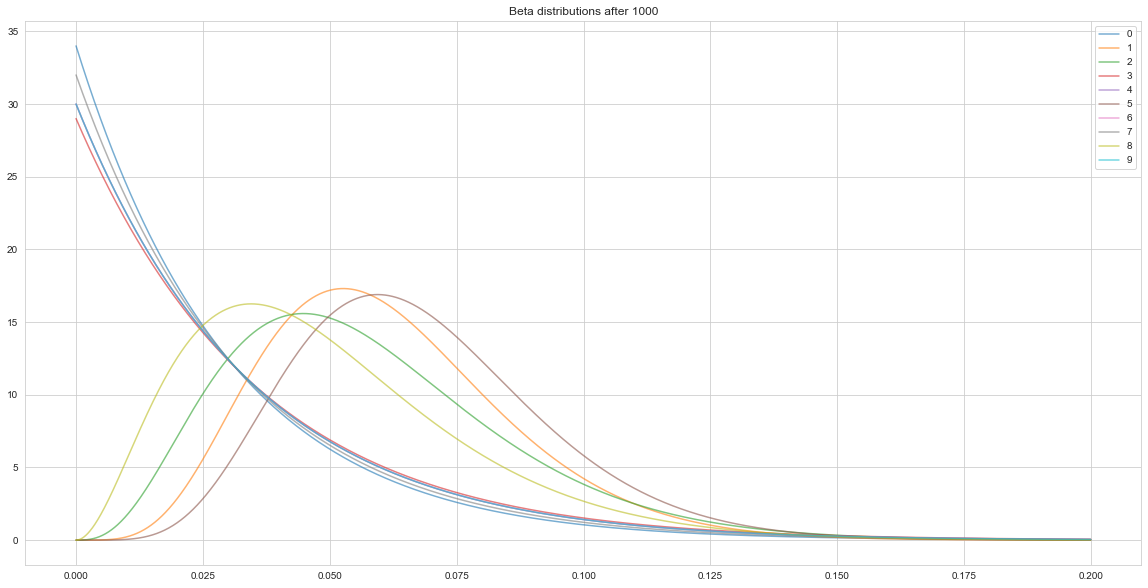

In [25]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 1000
plt.figure(figsize=(20, 10))
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend()
plt.show()

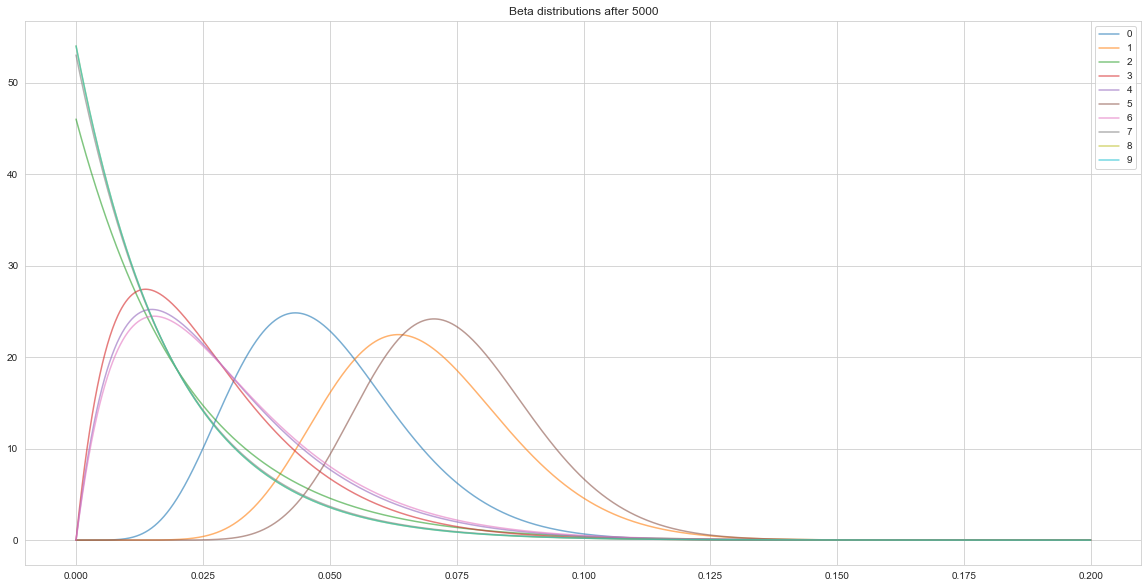

In [26]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 5000
plt.figure(figsize=(20, 10))
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend()

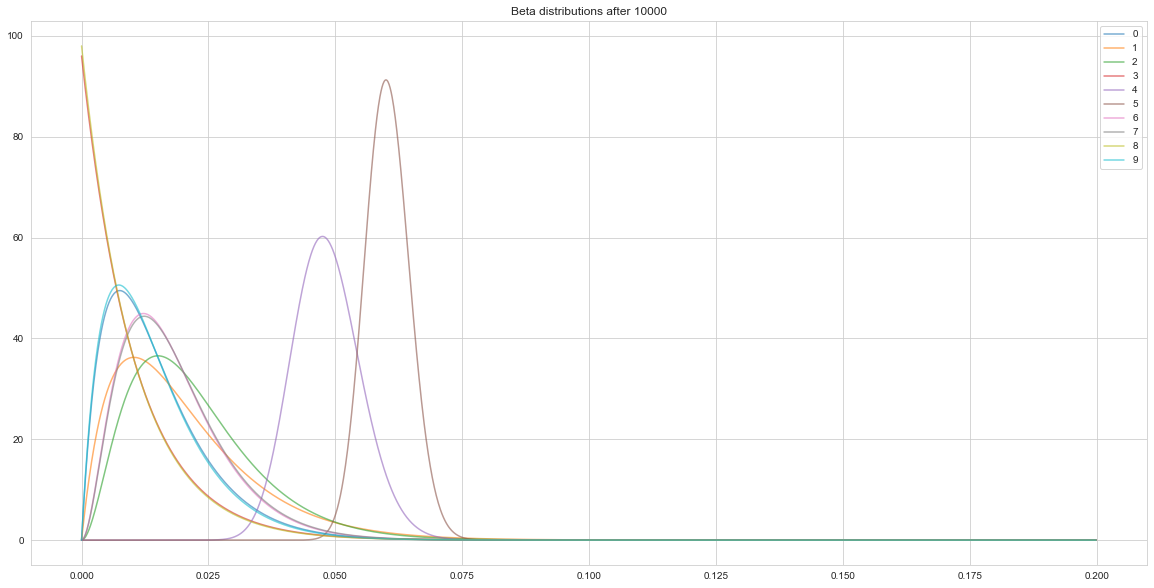

In [27]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 10000
plt.figure(figsize=(20, 10))
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend()
plt.show()

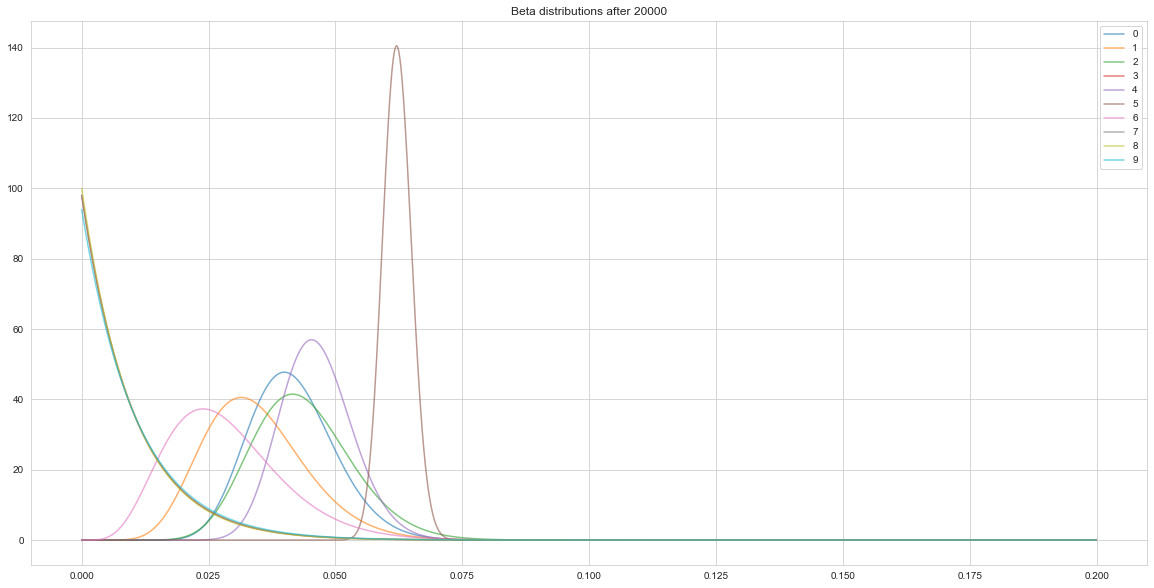

In [28]:
en = Environment(machines, payouts, n_rounds)
tsa = ThompsonSampler(env=en)
en.run(agent=tsa)
n_rounds = 20000
plt.figure(figsize=(20,10))
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = cmap[i]
    plt.plot(x, pdf, c=c, label=i, alpha=.6)
plt.title(f"Beta distributions after {n_rounds}")
plt.legend();

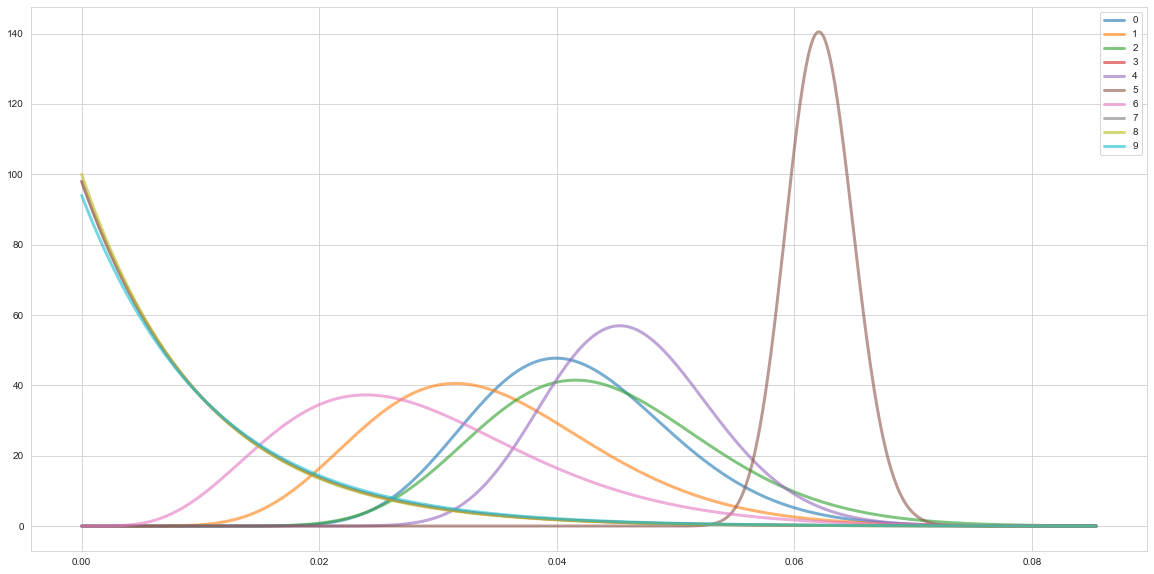

In [29]:
plt.figure(figsize=(20,10))
cmapi = iter(plt.cm.tab10(list(range(len(machines)))))
x = np.arange(0, max(tsa.theta) + 0.03, 0.0001)
for i in range(len(machines)):
    pdf = beta(tsa.a[i], tsa.b[i]).pdf(x)
    c = next(cmapi)
    plt.plot(x, pdf, c=c, label=i, linewidth=3, alpha=.6)
plt.legend()
plt.show()